In [1]:
import os
import glob
import re
import pandas as pd
from dodfminer.extract.polished.acts.aposentadoria import Retirements
import numpy as np
from itertools import zip_longest
from itertools import chain
from collections import Counter
import gc
from matplotlib import pyplot as plt

dncols = ['date', 'num']

In [2]:
def get_reverse_date(s):
    date = re.search( r'((\d+)[-](\d+)[-](\d+))', s)
    date = date.group()
    date = '-'.join(date.split('-')[::-1])
    return date

def get_num(s):
    return int(re.search('(\d+)', s).group())

## Quantos DODFs baixados?

In [3]:
df = pd.DataFrame()
dodfs_text = glob.glob('data/dodfs_flat/*.txt')
df['file'] = [i.split('/')[-1] for i in dodfs_text]
df['date'] = [get_reverse_date(s) for s in df.file]
# df['date'] = pd.to_datetime(df.date)
df['num'] = [get_num(s) for s in df.file]

date_num_ctr = Counter(zip(df.date, df.num))

df.drop('file', axis=1, inplace=True)
len(dodfs_text)

595

# Quantos casos de haver + de um dodf por data?

In [4]:
Counter(date_num_ctr.values())

Counter({2: 68, 1: 447, 3: 4})

## Quantos tiveram aposentadoria detectada?

In [5]:
%%time
dodfs_ext = [Retirements(i, 'regex') for i in dodfs_text]

df['has_act'] = [not i.data_frame.empty for i in dodfs_ext] 
df['qtd_miner'] = [i.data_frame.shape[0] for i in dodfs_ext]
print("[DODFMINER] TOTAL DE ARQUIVOS COM APOSENTADORIAS:", df[df.has_act].shape[0])

[DODFMINER] TOTAL DE ARQUIVOS COM APOSENTADORIAS: 227
CPU times: user 13.8 s, sys: 333 ms, total: 14.1 s
Wall time: 15 s


In [39]:
douro = pd.read_csv('data/aposentadoria-ouro/aposentaria-ouro-®.csv',
            sep='®', engine='python', index_col=False,)

# douro_quadro = douro[douro.QUADRO.notna()].copy()

douro_ctr = pd.read_csv('data/date_num_qtd_ouro.csv')
douro_ctr.set_index(['date', 'num'], inplace=True)

dminer_ctr = df[df.has_act].copy()
dminer_ctr['date'] = dminer_ctr.date.map(lambda x: '-'.join(x.split('-')[::-1]))
dminer_ctr.sort_values(['date', 'num'], inplace=True)
dminer_ctr.set_index(['date', 'num'], inplace=True)
dminer_ctr.drop('has_act', axis=1, inplace=True)
dminer_ctr = dminer_ctr.groupby(['date', 'num']).sum()

douro_ctr.shape, dminer_ctr.shape

((219, 1), (226, 1))

In [40]:
np.all(
    douro_ctr.values
    ==
    douro_ctr.groupby(['date', 'num']).sum()
)

True

In [41]:
# 'TIPO_DODF' é apenas uma coluna para depois contar
cols = ['DATA_DODF', 'NUM_DODF', 'TIPO_DODF']


dfcp = douro[cols].copy()
dfcp.rename({'DATA_DODF':'date', 'NUM_DODF':'num'}
         , axis=1, inplace=True)

gp_ouro = dfcp.groupby(['date', 'num']).count()
gp_ouro.columns = ['qtd_ouro']
gp_ouro.sort_values(['date', 'num'], inplace=True)

In [62]:
false_positive = pd.DataFrame(index=set(dminer_ctr.index) - set(douro_ctr.index))
false_negative = pd.DataFrame(index=set(douro_ctr.index) - set(dminer_ctr.index))

true_positive_negative = pd.DataFrame(
    index=set.intersection(set(douro_ctr.index) , set(dminer_ctr.index))
)

# false_positive['qtd_miner'] = dminer_ctr.loc[false_positive.index]
# false_negative['qtd_ouro'] = douro_ctr.copy().loc[false_negative.index]

true_positive_negative['qtd_ouro'] = douro_ctr.loc[true_positive_negative.index]
true_positive_negative['qtd_miner'] = dminer_ctr.loc[true_positive_negative.index]

false_positive.shape, false_negative.shape, true_positive_negative.shape

((17, 1), (10, 1), (209, 2))

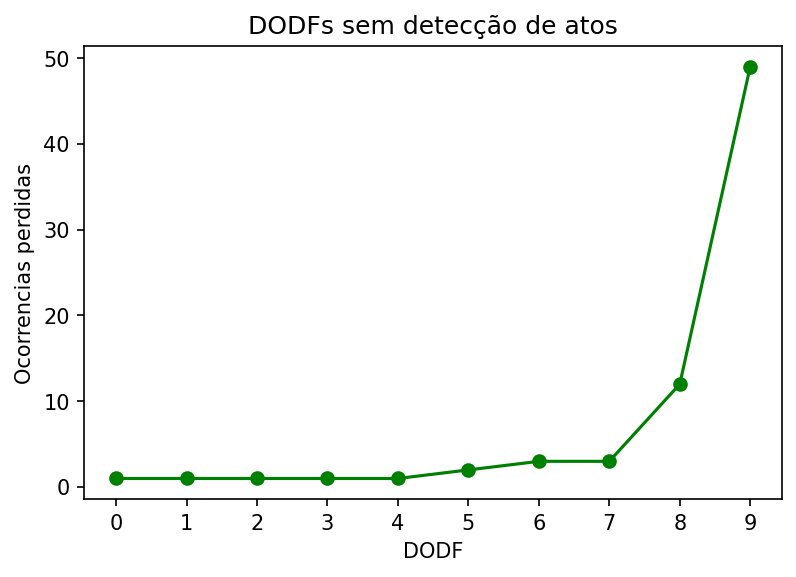

In [87]:
plt.figure(1,dpi=150)
plt.plot(sorted(false_negative.qtd_ouro.values), marker='o', color='g')
plt.ylabel('Ocorrencias perdidas')
plt.xlabel('DODF')
plt.title('DODFs sem detecção de atos')
plt.xticks(range(false_negative.shape[0]));

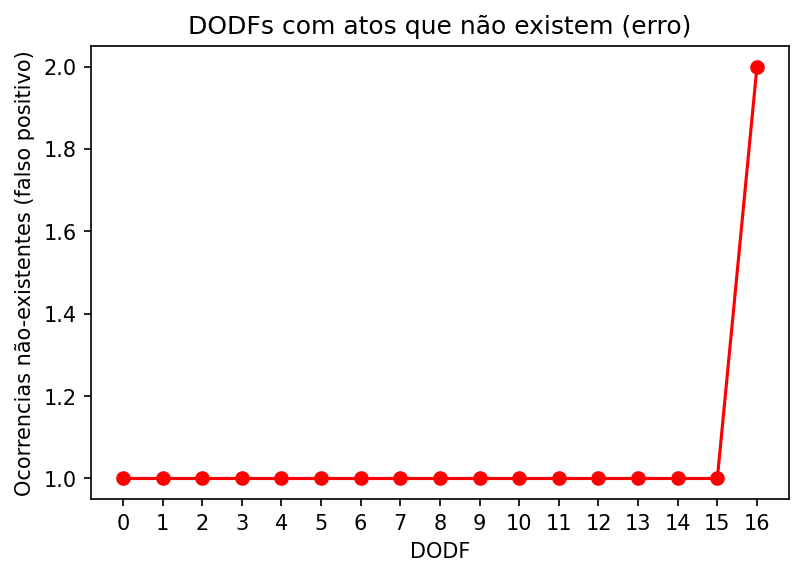

In [89]:
plt.figure(1,dpi=150)
plt.plot(sorted(false_positive.qtd_miner.values), marker='o', color='r')
plt.ylabel('Ocorrencias não-existentes (falso positivo)')
plt.xlabel('DODF')
plt.title('DODFs com atos que não existem (erro)')
plt.xticks(range(false_positive.shape[0]));

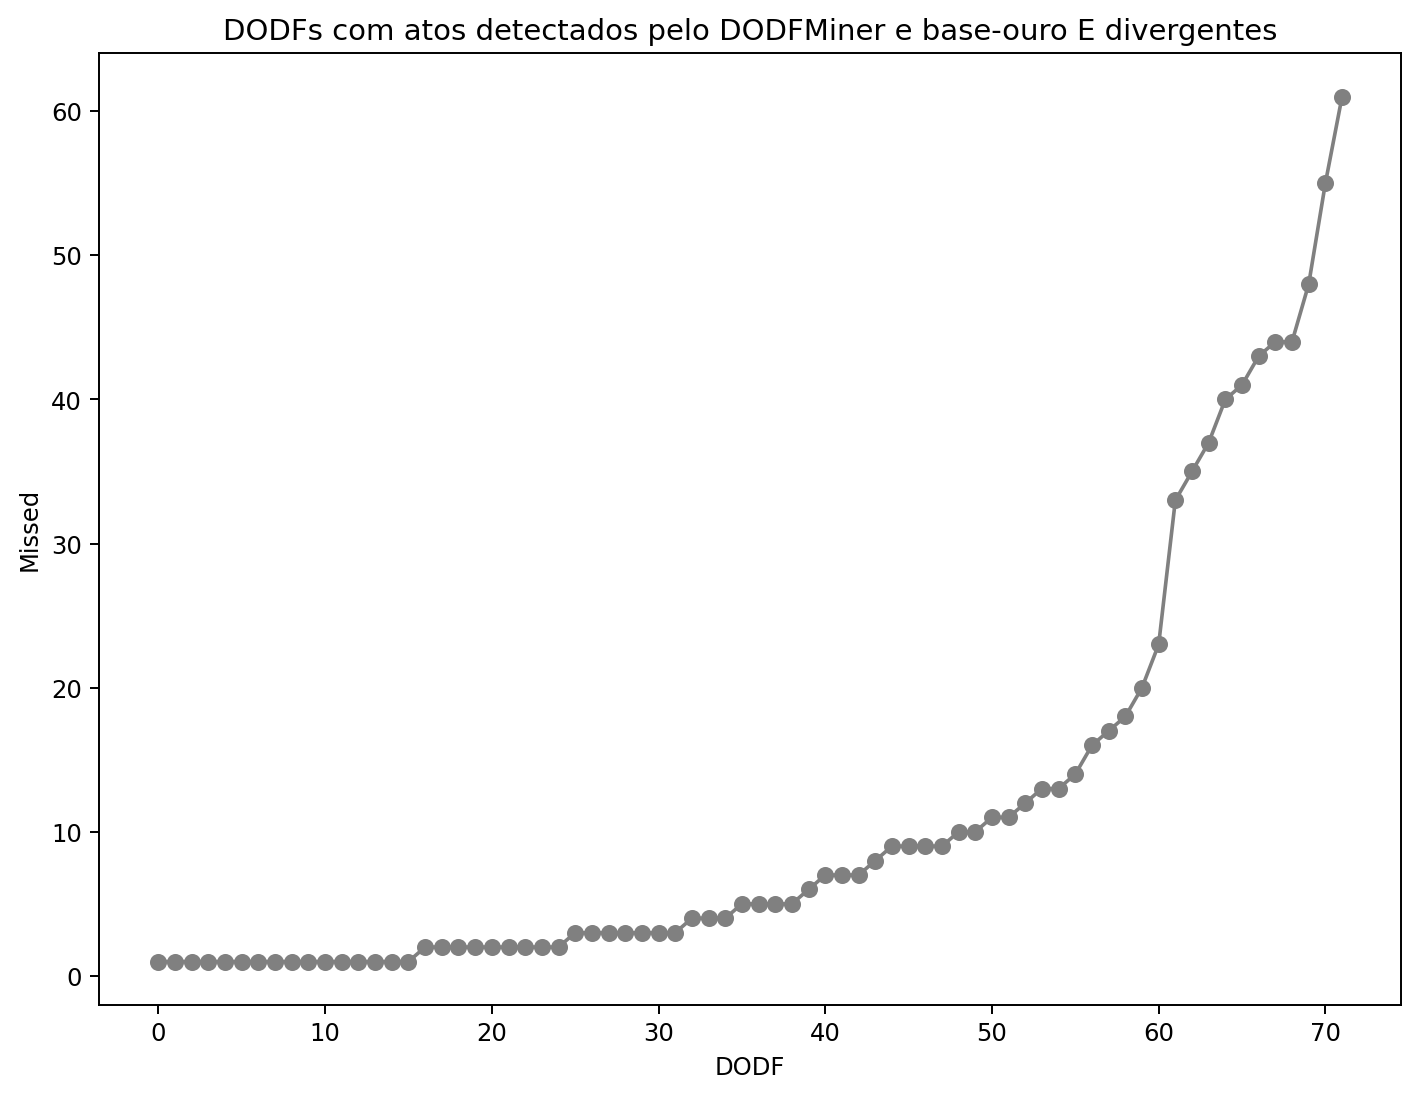

In [154]:
plt.figure(1, figsize=(9.6, 7.2),dpi=175)
diff = true_positive_negative.qtd_ouro - true_positive_negative.qtd_miner
pos_diff = [i for i in diff if i > 0]
plt.plot(sorted(pos_diff),
         marker='o',
         color='gray',
        )
plt.ylabel('Missed')
plt.xlabel('DODF')
plt.title('DODFs com atos detectados pelo DODFMiner e base-ouro E divergentes');
# plt.xticks(range(len(pos_diff)));

# Abaixo o número de DODFs cuja quantidade de atos encontrados foi a mesma

In [114]:
print(diff.shape[0] - len(pos_diff))

137


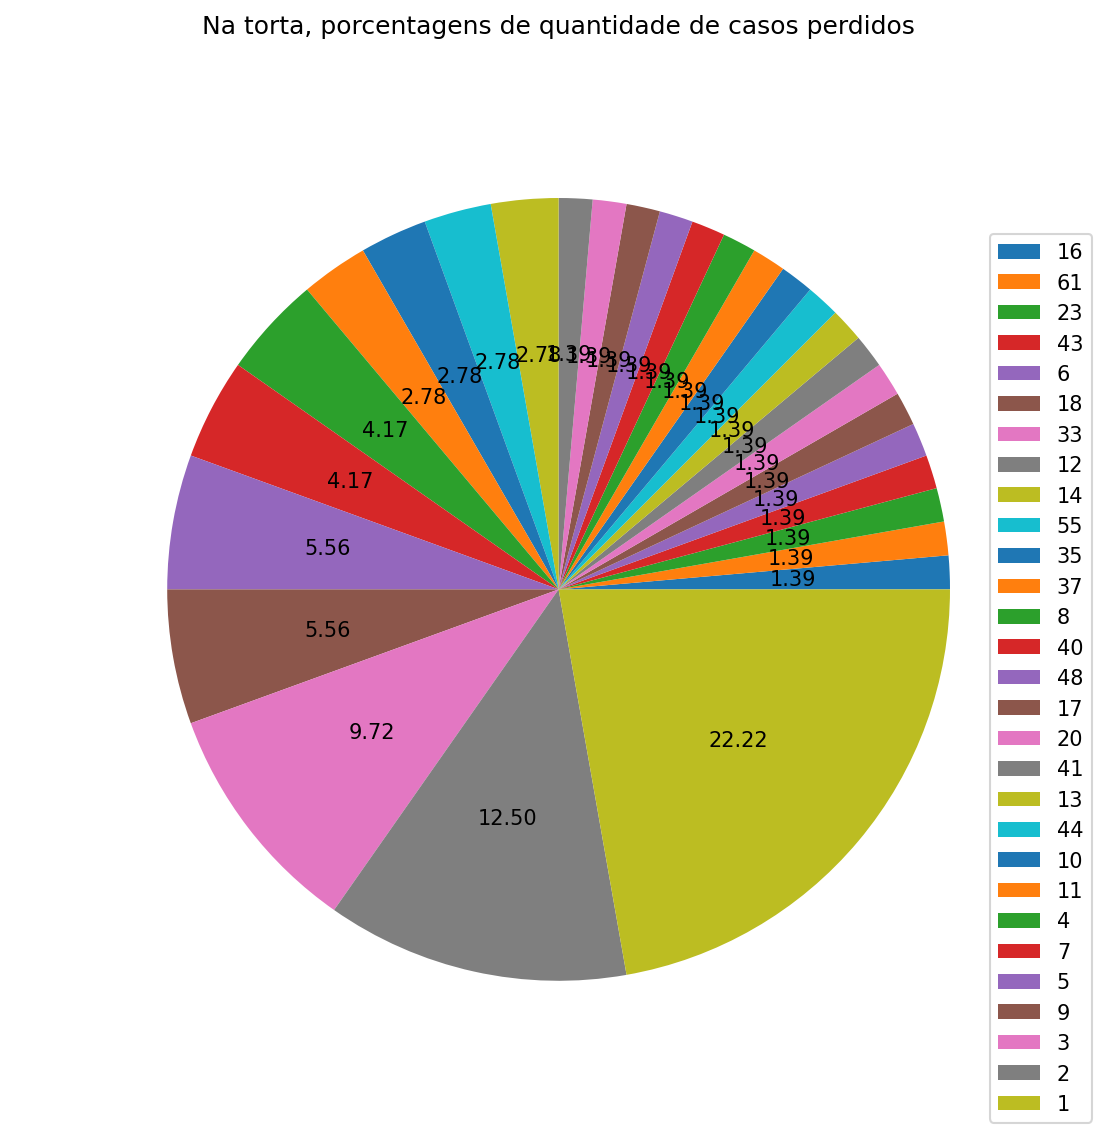

In [152]:
plt.figure(1, figsize=(12.8, 9.6),dpi=150)
diff_freq_qtd = Counter(pos_diff)
df_ = pd.DataFrame({
    'freq': list(diff_freq_qtd.values()),
    'qtd': list(diff_freq_qtd.keys())
})

df_.sort_values('freq',inplace=True)
plt.pie(
    x=df_.freq, autopct='%.2f', center=(50, 0),
    radius=.9
);
plt.legend(df_.qtd.astype(str), loc='lower right');
plt.title('Na torta, porcentagens de quantidade de casos perdidos');

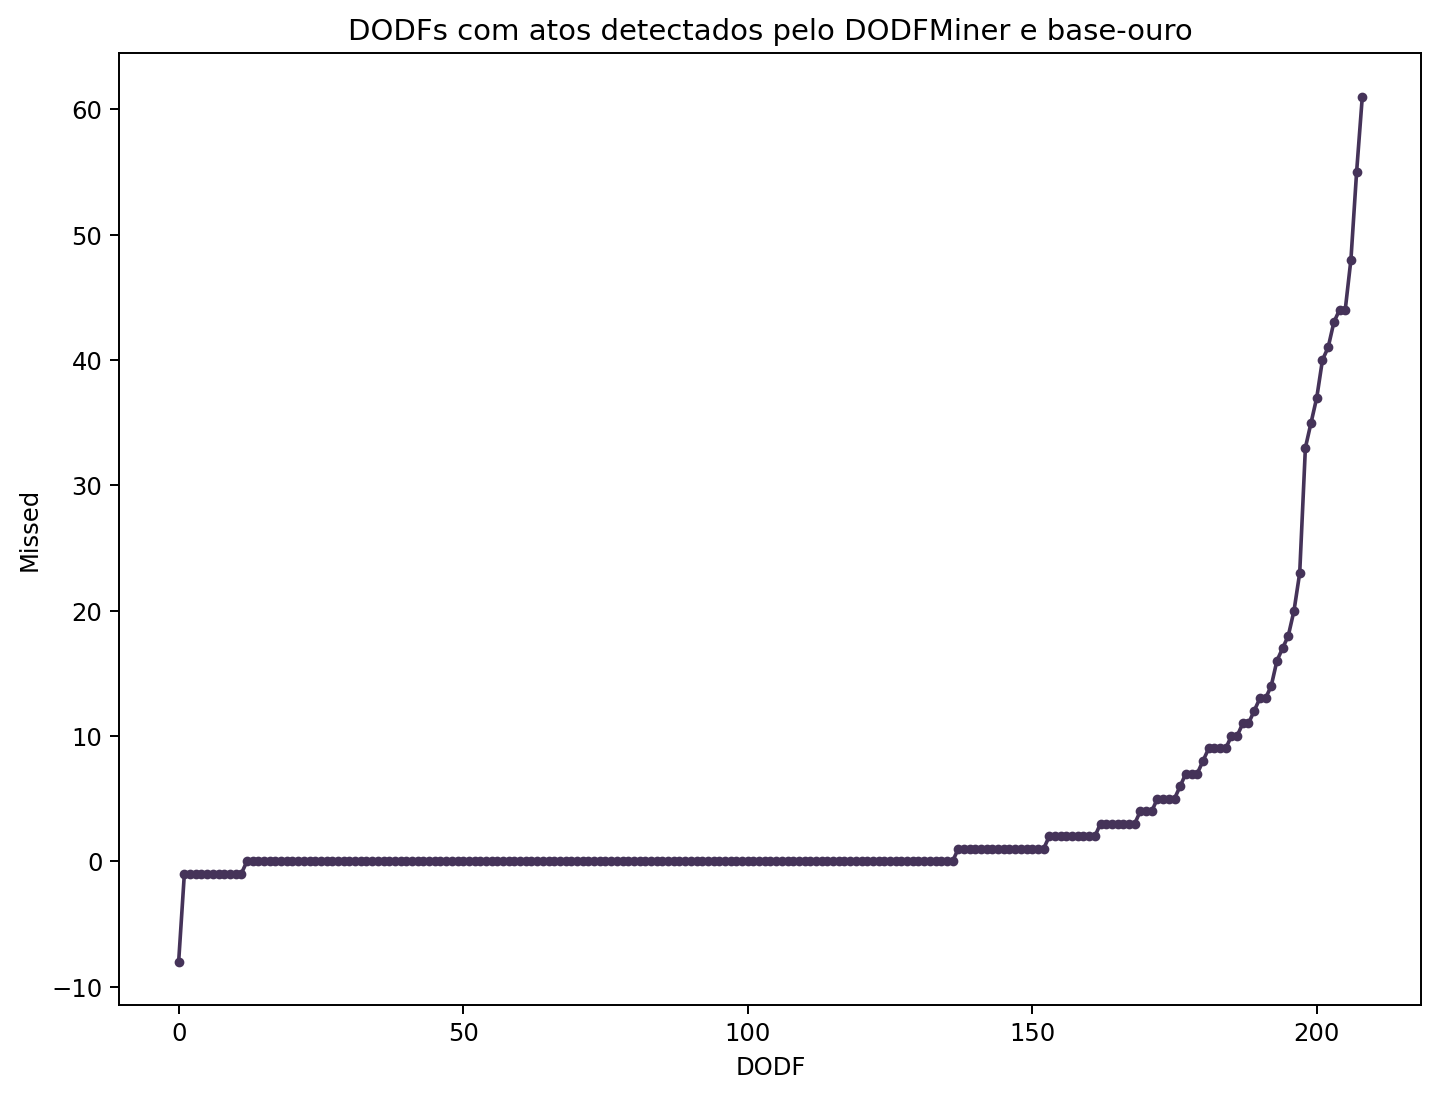

In [157]:
plt.figure(1, figsize=(9.6, 7.2),dpi=175)
diff = list(true_positive_negative.qtd_ouro - true_positive_negative.qtd_miner)
# pos_diff = [i for i in diff if i > 0]
plt.plot(sorted(diff),
         marker='.',
         color='#453359',
        )
plt.ylabel('Missed')
plt.xlabel('DODF')
plt.title('DODFs com atos detectados pelo DODFMiner e base-ouro');
# plt.xticks(range(len(pos_diff)));

In [119]:
diff_freq_qtd.values()

dict_values([2, 1, 9, 7, 3, 2, 1, 1, 16, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 3, 1, 1, 2, 1, 1, 2, 1, 1, 1])

In [120]:
diff_freq_qtd.keys()

dict_keys([11, 41, 2, 3, 7, 13, 20, 17, 1, 48, 40, 9, 37, 35, 16, 14, 12, 33, 5, 4, 18, 6, 44, 43, 23, 10, 61, 55, 8])